In this notebook, we're going to build a very simple neural network in PyTorch to do handwritten digit classification.
First, we'll start with some exploration of the MNIST dataset, explaining how we load and format the data.
We'll then jump into motivating and then implementing the logistic regression model, including the forward and backwards pass, loss functions, and optimizers.
After training the model, we'll evaluate how we did and visualize what we've learned.
Finally, we'll refactor our code in an object-oriented manner, using higher level APIs.

Before we get started, some imports for the packages we'll be using:

Matplotlib inline

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28. We'll be using it as our example dataset for this section of the tutorial, with the goal being to predict which digit is in each image.

Download the train and test set of MNIST

In [4]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw




Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw




Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw




Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


# Pick out the 4th (0-indexed) example from the training set

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


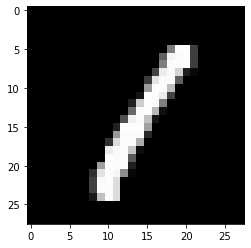

In [6]:
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

DataLoader to take care of shuffling and batching

In [7]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

 minibatch drawn from a DataLoader:

In [8]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


Convert our inputs into row vectors (a.k.a. flattening), we use view(), the equivalent of NumPy's reshape()

In [9]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


To get our predicted probabilities of each digit, let's first start with the probability of a digit being a 1 like the image above. For our simple model, we can start by applying a linear transformation. That is, we multiply each pixel  𝑥𝑖  of the input row vector by a weight  𝑤𝑖,1 , sum them all together, and then add a bias  𝑏1 .
𝑦1=∑𝑖𝑥𝑖𝑤𝑖,1+𝑏1
 Remember though, our original goal was to identify all 10 digits, so we actually have:
 𝑦0=∑𝑖𝑥𝑖𝑤𝑖,0+𝑏0 to 𝑦9=∑𝑖𝑥𝑖𝑤𝑖,9+𝑏9

 We can express this in matrix form as:

𝑦=𝑥𝑊+𝑏

To take advantage of parallel computation, we commonly process multiple inputs  𝑥  at once, in a minibatch. We can stack each input  𝑥  into a matrix  𝑋 , giving us

𝑌=𝑋𝑊+𝑏

In our specific example, the minibatch size  𝑚  is  100 , the dimension of the data is  28×28=784 , and the number of classes  𝑐  is  10 . While  𝑋  and  𝑌  are matrices due to the batching, conventionally, they are often given lowercase variable names, as if they were for a single example. We will use x and y throughout.

The weight  𝑊  and bias  𝑏  make up the parameters of this model. When we say that we want to "learn the model," what we're really trying to do is find good values for every element in  𝑊  and  𝑏 . Before we begin learning, we need to initialize our parameters to some value, as a starting point. Here, we don't really know what the best values are, so we going to initialize  𝑊  randomly (using something called Xavier initialization), and set  𝑏  to a vector of zeros

Randomly initialize weights W

In [10]:
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

As both W and b are parameters we wish to learn, we set requires_grad to True. This tells PyTorch's autograd to track the gradients for these two variables, and all the variables depending on W and b.

With these model parameters, we compute  𝑦 :

Linear transformation with W and b

In [11]:
y = torch.matmul(x, W) + b

In [12]:
print(y[0,:])

tensor([ 0.1018, -0.3237, -0.1220,  0.1298,  0.0733,  0.1640,  0.0698,  0.2573,
        -0.2050, -0.0024], grad_fn=<SliceBackward>)


We can interpret these values (aka logits)  𝑦  as probabilities if we normalize them to be positive and add up to 1. In logistic regression, we do this with a softmax:

𝑝(𝑦𝑖)=softmax(𝑦𝑖)=exp(𝑦𝑖)∑𝑗exp(𝑦𝑗)

We can compute the softmax ourselves using the above formula if we'd like, but PyTorch already has the softmax function in torch.nn.functional:

Softmax to probabilities from equation

In [13]:
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

py[0] from equation: tensor([0.1076, 0.0703, 0.0860, 0.1107, 0.1046, 0.1145, 0.1042, 0.1257, 0.0792,
        0.0970], grad_fn=<SelectBackward>)


Softmax to probabilities with torch.nn.functional

In [14]:
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] with torch.nn.functional.softmax: tensor([0.1076, 0.0703, 0.0860, 0.1107, 0.1046, 0.1145, 0.1042, 0.1257, 0.0792,
        0.0970], grad_fn=<SelectBackward>)


The cross-entropy loss
We don't know the values of  𝑊  and  𝑏  yet! Remember how we initialized them randomly? Before we adjust any of the weights, we need a way to measure how the model is doing. Specifically, we're going to measure how badly the model is doing. We do this with a loss function, which takes the model's prediction and returns a single number (i.e. a scalar) summarizing model performance. This loss will inform how we adjust the parameters of the model.

The loss we commonly use in classification is cross-entropy, a concept from information theory. Explaining exactly what the cross-entropy represents goes slightly beyond the scope of this course, but you can think of it as a way of quantifying how far apart one distribution  𝑦′  is from another  𝑦 .

𝐻𝑦′(𝑦)=−∑𝑖𝑦′𝑖log(𝑦𝑖)

We focus here on supervised learning, a setting in which we have the labels. Our DataLoader automatically includes the corresponding labels for each of our inputs. Here are the labels from the first time we retrieved a minibatch:

In [15]:
print(labels.shape)

torch.Size([100])


Like the softmax operation, we can implement the cross-entropy directly from the equation, using the softmax output. However, as with the softmax, torch.nn.functional already has the cross-entropy loss implemented as well

Cross-entropy loss from equation

In [17]:
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

cross entropy from equation: 2.3473894596099854


Option 2: cross-entropy loss with torch.nn.functional

In [18]:
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy with torch.nn.functional.cross_entropy: 2.3473894596099854


Now that we have the loss as a way of quantifying how badly the model is doing, we can improve our model by changing the parameters in a way that minimizes the loss. For neural networks, the common way of doing this is with backpropagation: we take the gradient of the loss with respect to  𝑊  and  𝑏  and take a step in the direction that reduces our loss.

If we were not using a deep learning framework like PyTorch, we would have to go through and derive all the gradients ourselves by hand, then code them into our program. We certainly still could. However, with modern auto-differentiation libraries, it's much faster and easier to let the computer do it.

First, we need to create an optimizer. There are many choices, but since logistic regression is fairly simple, we'll use standard stochastic gradient descent (SGD), which makes the following update:

𝜃𝑡+1=𝜃𝑡−𝛼∇𝜃
 
where  𝜃  is a parameter,  𝛼  is our learning rate (step size), and  ∇𝜃  is the gradient of our loss with respect to  𝜃 .

Optimizer

In [19]:
optimizer = torch.optim.SGD([W,b], lr=0.1)

When we created our parameters  𝑊  and  𝑏 , we indicated that they require gradients. To compute the gradients for  𝑊  and  𝑏 , we call the backward() function on the cross-entropy loss.

In [20]:
cross_entropy.backward()

Each of the variables that required gradients have now accumulated gradients. We can see these for example on b:

In [21]:
b.grad

tensor([ 0.0405, -0.0327,  0.0269,  0.0599, -0.0175, -0.0225,  0.0041,  0.0208,
        -0.0273, -0.0520])

To apply the gradients, we could manually update  𝑊  and  𝑏  using the update rule  𝜃𝑡+1=𝜃𝑡−𝛼∇𝜃 , but since we have an optimizer, we can tell it to perform the update step for us:

In [22]:
optimizer.step()

We set our learning rate to 0.1, so b has been updated by -0.1*b.grad:

In [ ]:
b

We've now successfully trained on a minibatch! However, one minibatch probably isn't enough. At this point, we've trained the model on 100 examples out of the 60000 in the training set. We're going to need to repeat this process, for more of the data.

One more thing to keep in mind though: gradients calculated by backward() don't override the old values; instead, they accumulate. Therefore, you'll want to clear the gradient buffers before you compute gradients for the next minibatch.

In [23]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([ 0.0405, -0.0327,  0.0269,  0.0599, -0.0175, -0.0225,  0.0041,  0.0208,
        -0.0273, -0.0520])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Model Training
To train the model, we just need repeat what we just did for more minibatches from the training set. As a recap, the steps were:

Draw a minibatch
Zero the gradients in the buffers for W and b
Perform the forward pass (compute prediction, calculate loss)
Perform the backward pass (compute gradients, perform SGD step)
Going through the entire dataset once is referred to as an epoch. In many cases, we train neural networks for multiple epochs, but here, a single epoch is enough. We also wrap the train_loader with tqdm. This isn't neccessary, but it adds a handy progress bar so we can track our training progress.

Iterate through train set minibatchs 

In [24]:
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

Testing
Now let's see how we did! For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. We then compute an accuracy by seeing how many we got correct. We're going to wrap evaluation with torch.no_grad(), as we're not interested in computing gradients during evaluation. By turning off the autograd engine, we can speed up evaluation.

In [25]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.902899980545044


Not bad for a simple model and a few lines of code. Before we conclude this example, there's one more interesting thing we can do. Normally, it can be difficult to inspect exactly what the filters in a model are doing, but since this model is so simple, and the weights transform the data directly to their logits, we can actually visualize what the model's learning by simply plotting the weights. The results look pretty reasonable:

Get weights

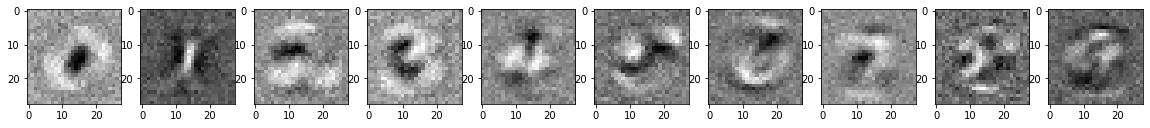

In [26]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

THE FULL CODE

In [27]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9020000100135803
